#Predicting Future Stock Market Trends with Python & Machine Learning

Credit:  https://github.com/lucasrea/StockForecast/blob/master/StockAnalysis.ipynb

Step 1. Imports and Data Collection

In [ ]:
!pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install finta

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install cryptocmd

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import yfinance as yf
import datetime
import pandas as pd
import numpy as np
from finta import TA
import matplotlib.pyplot as plt

from sklearn import svm
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, mean_squared_error, accuracy_score
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn import metrics


Financial Technical Analysis Indicators

https://github.com/peerchemist/finta

In [ ]:
"""
Defining some constants for data mining
"""

NUM_DAYS = 10000     # The number of days of historical data to retrieve
INTERVAL = '1d'     # Sample rate of historical data
symbol = 'GE'      # Symbol of the desired stock. (e.g. GE, VOO. Vanguard 500 Index Fund ETF, )
currency = ''
crypto  = ''

# List of symbols for technical indicators
INDICATORS = ['RSI', 'MACD', 'STOCH','ADL', 'ATR', 'MOM', 'MFI', 'ROC', 'OBV', 'CCI', 'EMV', 'VORTEX']

Pull historical data from Yfinance and normalize the data

[*********************100%***********************]  1 of 1 completed
                 open       high        low      close  Adj Close   volume
Date                                                                      
1995-04-28  72.275642  72.756409  71.794868  71.794868  36.296970  1984554
1995-05-01  71.794868  72.435898  71.794868  72.275642  36.540066  1347840
1995-05-02  71.955132  72.435898  71.794868  72.115387  36.459015  1305096
1995-05-03  72.275642  73.237183  72.275642  72.596153  36.702080  1691274
1995-05-04  72.756409  74.198715  72.435898  73.237183  37.026165  2134236


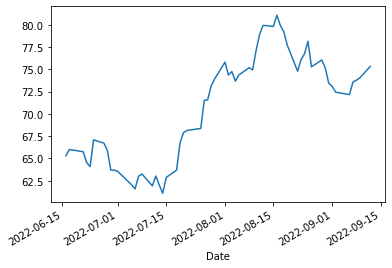

In [ ]:
"""
Next we pull the historical data using yfinance
Rename the column names because finta uses the lowercase names
"""

start = (datetime.date.today() - datetime.timedelta( NUM_DAYS ) )
end = datetime.datetime.today()

data = yf.download(symbol, start=start, end=end, interval=INTERVAL)
data.rename(columns={"Close": 'close', "High": 'high', "Low": 'low', 'Volume': 'volume', 'Open': 'open'}, inplace=True)
print(data.head())

tmp = data.iloc[-60:]
tmp['close'].plot()

#Step 2. Data Processing & Feature Engineering

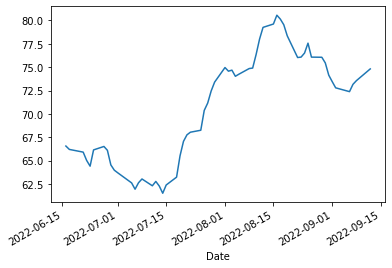

In [ ]:
"""
Next we clean our data and perform feature engineering to create new technical indicator features that our
model can learn from
"""

def _exponential_smooth(data, alpha):
    """
    Function that exponentially smooths dataset so values are less 'rigid'
    :param alpha: weight factor to weight recent values more
    """
    
    return data.ewm(alpha=alpha).mean()

data = _exponential_smooth(data, 0.65)

tmp1 = data.iloc[-60:]
tmp1['close'].plot()

#Compute Technical Indicators

In [ ]:
def _get_indicator_data(data):
    """
    Function that uses the finta API to calculate technical indicators used as the features
    :return:
    """

    for indicator in INDICATORS:
        ind_data = eval('TA.' + indicator + '(data)')
        if not isinstance(ind_data, pd.DataFrame):
            ind_data = ind_data.to_frame()
        data = data.merge(ind_data, left_index=True, right_index=True)
    data.rename(columns={"14 period EMV.": '14 period EMV'}, inplace=True)

    # Also calculate moving averages for features
    data['ema50'] = data['close'] / data['close'].ewm(50).mean()
    data['ema21'] = data['close'] / data['close'].ewm(21).mean()
    data['ema15'] = data['close'] / data['close'].ewm(14).mean()
    data['ema5'] = data['close'] / data['close'].ewm(5).mean()

    # Instead of using the actual volume value (which changes over time), we normalize it with a moving volume average
    data['normVol'] = data['volume'] / data['volume'].ewm(5).mean()

    # Remove columns that won't be used as features
    del (data['open'])
    del (data['high'])
    del (data['low'])
    del (data['volume'])
    del (data['Adj Close'])
    
    return data

data = _get_indicator_data(data)
print(data.columns)

Index(['close', '14 period RSI', 'MACD', 'SIGNAL', '14 period STOCH %K', 'MFV',
       '14 period ATR', 'MOM', '14 period MFI', 'ROC', 'OBV', '20 period CCI',
       '14 period EMV', 'VIm', 'VIp', 'ema50', 'ema21', 'ema15', 'ema5',
       'normVol'],
      dtype='object')


#Plot Technical Indicators

In [ ]:
def plot_technical_indicators(dataset, last_days):
    plt.figure(figsize=(16, 10), dpi=100)
    shape_0 = dataset.shape[0]
    xmacd_ = shape_0-last_days
    
    dataset = dataset.iloc[-last_days:, :]
    x_ = range(3, dataset.shape[0])
    x_ =list(dataset.index)
    
    # Plot first subplot
    plt.subplot(2, 1, 1)
    plt.plot(dataset['MACD'],label='MACD', color='g',linestyle='--')
    plt.plot(dataset['Close'],label='Closing Price', color='b')
    plt.plot(dataset['14 period RSI'],label='RSI', color='y')
    plt.plot(dataset['ema21'],label='EMA 21', color='r',linestyle='--')
    plt.plot(dataset['upper_band'],label='Upper Band', color='c')
    plt.plot(dataset['lower_band'],label='Lower Band', color='c')
    
    plt.fill_between(x_, dataset['lower_band'], dataset['upper_band'], alpha=0.35)
    plt.title('Technical indicators - last {} days.'.format(last_days))
    plt.ylabel('USD')
    plt.legend()

    # Plot second subplot
    plt.subplot(2, 1, 2)
    plt.title('MACD')
    plt.plot(dataset['MACD'],label='MACD', linestyle='-.')
    plt.hlines(15, xmacd_, shape_0, colors='g', linestyles='--')
    plt.hlines(-15, xmacd_, shape_0, colors='g', linestyles='--')
    plt.plot(dataset['14 period STOCH %K'],label='14 period STOCH %K', color='b',linestyle='-')
  
    plt.legend()
    plt.show()

Keep a small set of data to predict future values with

In [ ]:
live_pred_data = data.iloc[-16:-11]

Next we calculate truth values.

E.g. To buy(1) or sell(0)

Note: We need to remove all the NaN value, as well as removing the 'close' column

In [ ]:
def _produce_prediction(data, window):
    """
    Function that produces the 'truth' values
    At a given row, it looks 'window' rows ahead to see if the price increased (1) or decreased (0)
    :param window: number of days, or rows to look ahead to see what the price did
    """
    
    prediction = (data.shift(-window)['close'] >= data['close'])
    prediction = prediction.iloc[:-window]
    data['pred'] = prediction.astype(int)
    
    return data

data = _produce_prediction(data, window=15)
del (data['close'])
data = data.dropna() # Some indicators produce NaN values for the first few rows, we just remove them here
data.tail()
print(len(data))

6863


In [ ]:
#Step 3. Model Creation

In [ ]:
def _train_random_forest(X_train, y_train, X_test, y_test):

    """
    Function that uses random forest classifier to train the model
    :return:
    """
    
    # Create a new random forest classifier
    rf = RandomForestClassifier()
    
    # Dictionary of all values we want to test for n_estimators
    params_rf = {'n_estimators': [110,130,140,150,160,180,200]}
    
    # Use gridsearch to test all values for n_estimators
    rf_gs = GridSearchCV(rf, params_rf, cv=5)
    
    # Fit model to training data
    rf_gs.fit(X_train, y_train)
    
    # Save best model
    rf_best = rf_gs.best_estimator_
    
    # Check best n_estimators value
    print(rf_gs.best_params_)
    
    prediction = rf_best.predict(X_test)

    print(classification_report(y_test, prediction))
    print(confusion_matrix(y_test, prediction))
    
    return rf_best

In [ ]:
def _train_KNN(X_train, y_train, X_test, y_test):

    knn = KNeighborsClassifier()
    # Create a dictionary of all values we want to test for n_neighbors
    params_knn = {'n_neighbors': np.arange(1, 25)}
    
    # Use gridsearch to test all values for n_neighbors
    knn_gs = GridSearchCV(knn, params_knn, cv=5)
    
    # Fit model to training data
    knn_gs.fit(X_train, y_train)
    
    # Save best model
    knn_best = knn_gs.best_estimator_
     
    # Check best n_neigbors value
    print(knn_gs.best_params_)
    
    prediction = knn_best.predict(X_test)

    print(classification_report(y_test, prediction))
    print(confusion_matrix(y_test, prediction))
    
    return knn_best

#Voting classifier

In [ ]:
def _ensemble_model(rf_model, knn_model, X_train, y_train, X_test, y_test):
    
    # Create a dictionary of our models
    estimators=[('knn', knn_model), ('rf', rf_model)]
    
    # Create our voting classifier, inputting our models
    ensemble = VotingClassifier(estimators, voting='hard')
    
    #fit model to training data
    ensemble.fit(X_train, y_train)
    
    #test our model on the test data
    print(ensemble.score(X_test, y_test))
    
    prediction = ensemble.predict(X_test)

    print(classification_report(y_test, prediction))
    print(confusion_matrix(y_test, prediction))
    
    return ensemble

In [ ]:
#ensemble_model = _ensemble_model(rf_model, knn_model, gbt_model, X_train, y_train, X_test, y_test)

#Cross_Validation definition

In [ ]:
def cross_Validation(data):

    # Split data into equal partitions of size len_train
    
    num_train = 10 # Increment of how many starting points (len(data) / num_train  =  number of train-test sets)
    len_train = 40 # Length of each train-test set
    
    # Lists to store the results from each model
    rf_RESULTS = []
    knn_RESULTS = []
    gbt_RESULTS = []
    ensemble_RESULTS = []
    
    i = 0
    
    # Models which will be used
    rf = RandomForestClassifier()
    knn = KNeighborsClassifier()
    #gbt = GradientBoostingClassifier()

   
  
    
    
    # Create a tuple list of our models
    estimators=[('knn', knn), ('rf', rf)]
    ensemble = VotingClassifier(estimators, voting='soft')
    
    
    while True:
        
        # Partition the data into chunks of size len_train every num_train days
        df = data.iloc[i * num_train : (i * num_train) + len_train]
        i += 1
        #print(i * num_train, (i * num_train) + len_train)
        
        if len(df) < 40:
            break
        
        y = df['pred']
        features = [x for x in df.columns if x not in ['pred']]
        X = df[features]

        X_train, X_test, y_train, y_test = train_test_split(X, y, train_size= 7 * len(X) // 10,shuffle=False)
        
        # fit models
        rf.fit(X_train, y_train)
        knn.fit(X_train, y_train)
        ensemble.fit(X_train, y_train)
        #gbt.fit(X_train,y_train)

        

              
        # get predictions
        rf_prediction = rf.predict(X_test)
        knn_prediction = knn.predict(X_test)
        ensemble_prediction = ensemble.predict(X_test)
        
        
        #print('rf prediction is ', rf_prediction)
        #print('knn prediction is ', knn_prediction)
        #print('ensemble prediction is ', ensemble_prediction)
        #print('truth values are ', y_test.values)
        
        # determine accuracy and append to results
        rf_accuracy = accuracy_score(y_test.values, rf_prediction)
        knn_accuracy = accuracy_score(y_test.values, knn_prediction)
        ensemble_accuracy = accuracy_score(y_test.values, ensemble_prediction)

            
        #print(rf_accuracy)
        #print(knn_accuracy)
        #print(ensemble_accuracy)
        rf_RESULTS.append(rf_accuracy)
        knn_RESULTS.append(knn_accuracy)
        ensemble_RESULTS.append(ensemble_accuracy)
       
                
    print('RF Accuracy = ' + str( sum(rf_RESULTS) / len(rf_RESULTS)))
    print('KNN Accuracy = ' + str( sum(knn_RESULTS) / len(knn_RESULTS)))
    print('ENSEMBLE Accuracy = ' + str( sum(ensemble_RESULTS) / len(ensemble_RESULTS)))
    


Putting all together

In [ ]:
#Call  the cross validation function
cross_Validation(data)

RF Accuracy = 0.6326256710590532
KNN Accuracy = 0.634089799902391
ENSEMBLE Accuracy = 0.6466569058077106


##Verification of Results

In [ ]:
live_pred_data.head()

,close,14 period RSI,MACD,SIGNAL,14 period STOCH %K,MFV,14 period ATR,MOM,14 period MFI,ROC,OBV,20 period CCI,14 period EMV,VIm,VIp,ema50,ema21,ema15,ema5,normVol
Date,,,,,,,,,,,,,,,,,,,,
2022-08-19,78.355974,68.145119,2.970459,2.697071,66.984427,-5.437054e+08,1.648852,4.113702,64.251929,4.921754,-9.773857e+06,74.221874,0.072178,0.765881,1.150126,1.022459,1.068160,1.056782,1.007707,0.702257
2022-08-22,76.031590,56.193681,2.633499,2.684356,35.749358,-5.458369e+08,1.687334,1.179795,57.344124,2.712587,-1.440483e+07,12.133133,0.003452,0.815015,1.009627,0.992282,1.034758,1.023698,0.981443,0.875062
2022-08-23,76.076056,56.351389,2.343034,2.616092,36.346883,-5.464443e+08,1.724926,1.173427,58.469892,2.469998,-9.689082e+06,1.063661,-0.001239,0.800138,0.981129,0.993001,1.033702,1.022640,0.984969,0.907556
2022-08-24,76.507618,57.934286,2.123187,2.517511,42.146219,-5.461190e+08,1.752475,0.150698,64.790867,2.212135,-4.940864e+06,2.125280,0.011867,0.780075,1.010361,0.998661,1.037700,1.026495,0.992118,0.927123
2022-08-25,77.568666,61.619546,2.011388,2.416286,49.888244,-5.471240e+08,1.801965,-0.441257,71.046016,3.559337,1.021177e+05,37.376304,0.054901,0.717970,1.057588,1.012262,1.049606,1.037912,1.004893,0.987199
